# 在 Python 中实现 FIR 数字滤波器设计、可视化及实例应用

15343087 徐凯昕 光电子三班 信号与系统大作业

#### FIR filter is a category of filter with a finite impulse response to a finite length of signal, compared to IIR. In most of the cases the signals we meet in real life isn't infinite, at least for data or signal processing that only a finite partial of signals is what we care about. In this case, FIR filter is more important to work on.

In this project, with some previous Python programming experiences, I basically learned:
1. How to complete basic tasks of data processing with fundamental python packages. (numpy, scipy, etc.)
2. How to design digital FIR filters with different module of FIRs.
3. The difference between 2 methods of signal filtering encapsuled within scipy.signal package.
4. How to read, extract and process data from wfdb-python package, which is an open source ECG dataset.

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import wfdb
from IPython.display import display
from matplotlib.font_manager import FontProperties

myfont = FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
# set default size of plots
plt.rcParams['figure.figsize'] = (15, 4) 

### 1. Simple demonstration of Rect Low-pass filter

Rect LPF is one of the simplest and idealest FIR filters, it has a stair decrease in transition band. The frequency response is also idealish:
$h_{ideal}[n] = \frac{\sin(2 \pi f_c)}{\pi n} = 2f_c sinc(2f_c n)$ , but limit the frequency to a finite range (0 to L)

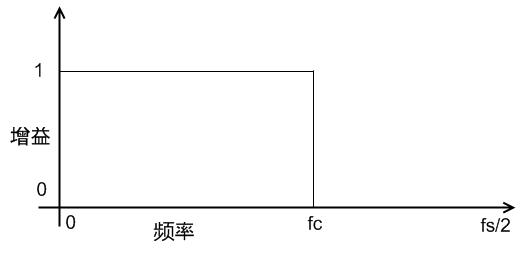

#### Calculate and demonstrate the Frequency Response:

In [2]:
# one side signal (非因果)
def sinc_n(M, fc):
    return 2 * fc * np.sinc(2 * fc * np.arange(0, M, 1.0))

In [3]:
# two side signal (因果)
def sincdouble_n(M, fc):
    return 2 * fc * np.sinc(2 * fc * np.arange(-M, M, 1.0))

In [4]:
def sinc_freqz(b, title, semilogx = False, showpart = False):
    ''' 
    calculate Z transform.
    Cut-out in time domain signal cause side lobes in Frequency Responce'''
    
    w, h = signal.freqz(b)
    h_dB = 20 * np.log10(abs(h))
    f = w / (np.pi)       #regularize frequncy to be between 0 and 1
    
    plt.rcParams['figure.figsize'] = (15, 4) 
    if showpart == False: plt.subplot(122)
    # select plot mode: log space or linear space
    if semilogx == True:
        plt.semilogx(f, h_dB)
    else:
        plt.plot(f, h_dB)
        plt.plot([0, 1], [-21, -21], 'k--', LineWidth = 1.0)
        plt.text(0.26, -21, 'MSB of sinc double = -21 dB', fontdict={'size': 16})
    plt.xlabel('$\omega$')
    plt.ylabel('$H (dB)$')
    
    # if compare between different sample number
    if showpart == False:
        plt.subplot(121)
        plt.stem(b)
        plt.plot(b, '--')
        plt.xlabel('$n$')
        plt.ylabel('$h(n)$')
        plt.title('FIR ' + title)
        plt.show()
    
    return f, h_dB

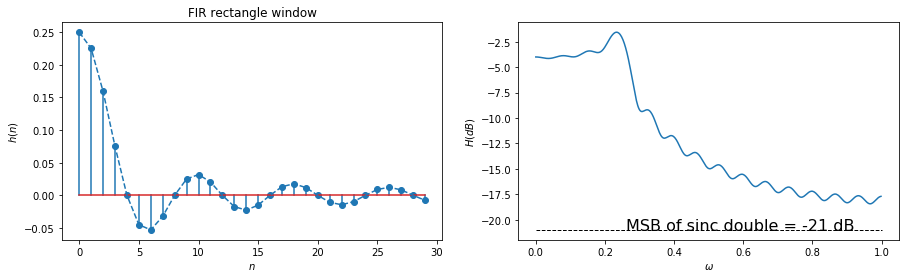

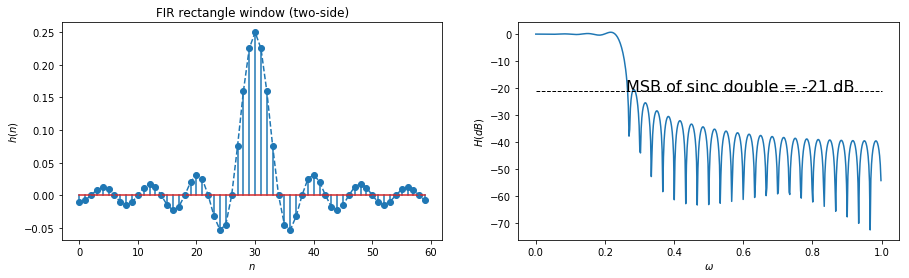

In [5]:
# M is width of window in time domain
M = 30
fc = 0.125
# one/two side sinc signal in time domain
b = sinc_n(M, fc)
b1 = sincdouble_n(M, fc)

f, h_dB = sinc_freqz(b, 'rectangle window')
f1, h1_dB = sinc_freqz(b1, 'rectangle window (two-side)')

将两种理想窗函数相比较后，右上角的子图中，低通旁瓣更加明显，并且低通滤波的效果比双边窗函数的要差得多。

The **MSB** (Min Stop Band Attenuation) of Two-side Rect window's frequency response is only $-21dB$, which is unsatisfying. The next thing to try might be sampling more data and see what will happen:

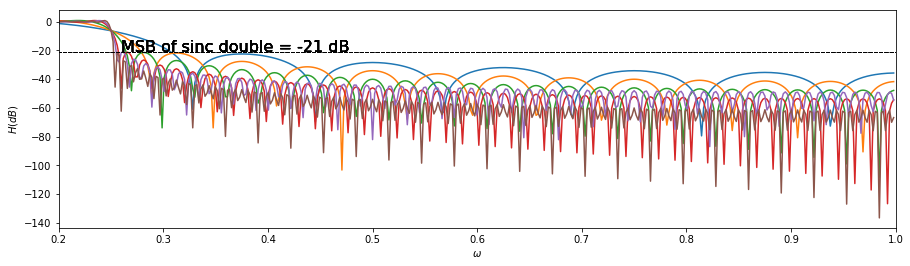

In [6]:
Ms = [8, 16, 32, 64, 90, 160]
cache = dict()
i = 0
for M in Ms:
    cache['b' + str(i)] = sincdouble_n(M, fc)
    _, _ = sinc_freqz(cache['b' + str(i)], 'rectangle window, M = '+str(M), showpart=True)
    i += 1
plt.xlim([0.2, 1])
plt.show()

### Conclusion: 
1. Increasment of sampling number doesn't help on MSB, in other word, larger attenuation or fall in transition band.
2. The 3 downward figure show that two-side Rect LPF has slightly larger MSB than one-side, which gives better performance. However, this simple window filter is still not practical to solve reality problems.

### 2. Some other Window Filters

To design a FIR filter with larger MSB than ideal window filter as several cells ago, people designed more complex window, their MSB is much larger than $-21dB$, for example, Bartlett window, Hannigng window, Hamming window, Blackman window, Kaiser window...   

Mostly they have complicated math expressions, but we can easily apply them in python thanks to scipy.signal.firwin()

In [7]:
def get_window(wintype, Nx, cutoff = 0.5):   # Nx is equivalent to M
    wins = dict()
    
    for w in wintype:
        win = signal.firwin(2 * Nx, cutoff, window=w)
        wins[w] = win
        
        plt.rcParams['figure.figsize'] = (15, 10) 
        plt.subplot(211)
        plt.plot(win, label = w)
        plt.xlabel('$n$')
        plt.ylabel('$w(n)$')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        plt.subplot(212)
    
        win_f, h = signal.freqz(win)
        plt.plot((win_f / (2 * np.pi))[200:], (20 * np.log10(abs(h)))[200:], label = w)
        plt.xlabel('$\omega$')
        plt.ylabel('$H (dB)$')
        plt.title('amplitude response')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return wins

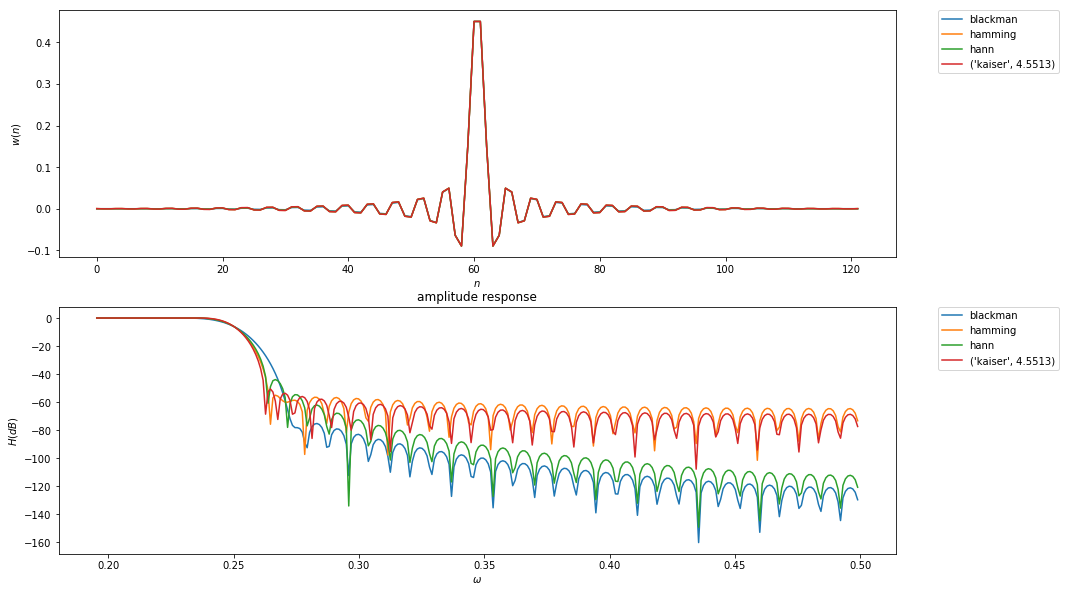

In [8]:
firwins = get_window(["blackman", 
            "hamming", 
            "hann", 
            ('kaiser', 4.5513)], 61)        #beta = 4.5513
plt.show()

### Conclusion:
1. All the window filters perform much better than ideal window filter on MSB.
2. Among these filters, given different value of parameter "M", Blackman window have largest MSB, yet also attenuate slower and smoother to stop band. The MSB of the Kaiser window can be adjusted by paramter $\beta$

Also, using blackman window to optimize the previous rect window filter and compare the Freq Responses:

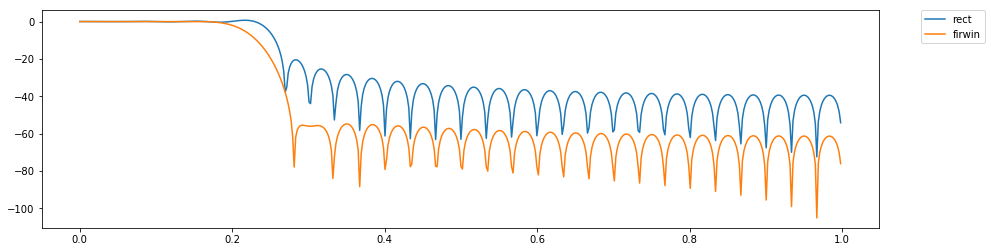

In [9]:
b3 = signal.firwin(len(b1), 0.22)

w3, h3 = signal.freqz(b3)

h3_dB = 20 * np.log10(abs(h3))
f3 = w3 / (np.pi)

plt.rcParams['figure.figsize'] = (15, 4) 
plt.plot(f1, h1_dB, label = 'rect')
plt.plot(f3, h3_dB, label = 'firwin')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Apply blackman window to filter the ideal FIR filter, the MSB is increased.

### 3. signal.filtfilt and signal.lfilter

Now assume that in an application, we built a FIR filter using Butterworth filter, and then filt a signal data. But there're basically two function for FIR filter: filtfilt and lfilter:

In [10]:
def filtfilt_demo(b,a,x, lim = (0, 400)):
    (l, h) = lim
    y = signal.filtfilt(b, a, x)
    plt.plot(y[l: h])
    plt.show()
    return y

In [11]:
def lfilter_demo(b,a,x, lim = (0, 400)):
    (l, h) = lim
    y = signal.lfilter(b, a, x)
    plt.plot(y[l: h])
    plt.show()
    return y

First, pass through the simple diverse frequency signal, compare the filtered signal using both function:

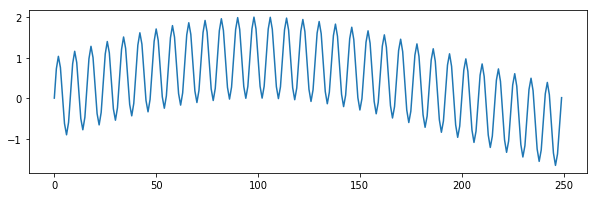

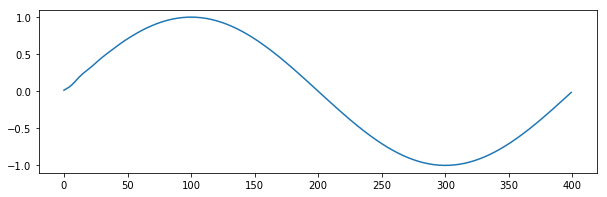

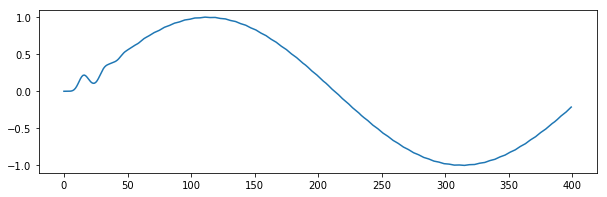

In [12]:
t = np.linspace(0, 1.0, 2001)

## contruct signal with a low freq component and a high freq component
x_high = np.sin(2 * np.pi * 5 * t)
x_low = np.sin(2 * np.pi * 250 * t)
x = x_high + x_low

plt.rcParams['figure.figsize'] = (10,3)
plt.plot(x[0:250])
plt.show()

# build Butterworth filter
nom, denom = signal.butter(8, 0.125, btype='low')    # LPF
_ = filtfilt_demo(nom, denom, x)
_ =lfilter_demo(nom,denom, x)

### Conclusion:
As we can see, the first filtered signal converge to the low freq component at the very beginning, while the second one need some delay.  
According to the offical doc, filtfilt apply the filter twice to the signal to get rid of the lag, while lfilter only apply once.

### 4. FIR application on ECG signal

ECG (electrocardiogram) is series of detection of heart beat of patients. It's important to illustrate a clean picture from a noisy and dirty signal from detectors(the noise is natural and unavoidable).  

#### First, read a record of a feature signal from wfdb dataset, select one channel from it that is quite noisy.

In [13]:
signals, fields=wfdb.srdsamp('sampledata/100', sampfrom=100, sampto=15000)
display(signals)
display(fields)

array([[-0.33 , -0.195],
       [-0.335, -0.185],
       [-0.33 , -0.185],
       ..., 
       [-0.52 , -0.275],
       [-0.54 , -0.315],
       [-0.545, -0.31 ]])

{'comments': ['unnecessary comment', '69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'fs': 360,
 'signame': ['MLII', 'V5'],
 'units': ['mV', 'mV']}

In [14]:
# Convert one channel to processable data
# Argument "fs_target" stands for resampling freq
data, _ = wfdb.processing.resample_sig(x=signals[:,0], fs=fields['fs'], fs_target=1280)

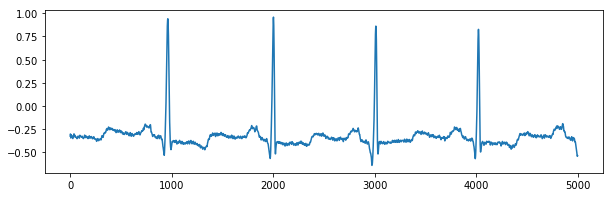

In [15]:
plt.plot(data[:5000])
plt.show()

ECG record is quite noisy, but we can still see the pattern in every period: one high impulse followed by some small fluctuations.   
The relatively small oscillation is the high freq noise we don't want.

#### Next, check frequency spectrum of the signal.

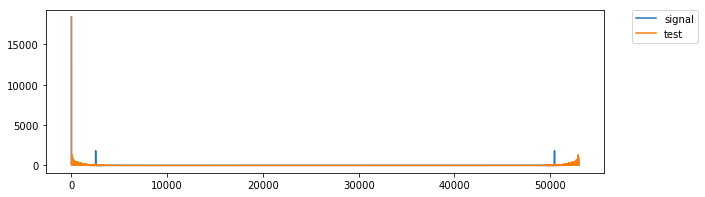

In [16]:
# select a test freqency to observe the spectrum of the signal
f_test = 0.3

# add a f_test frequency sin wave to the signal
data_prime = data +  0.1 * np.sin(f_test * np.arange(0, len(data), 1.0))

spectrum = np.fft.fft(data_prime)
spectrum_test = np.fft.fft(data)
plt.plot(abs(spectrum), label = 'signal')
plt.plot(abs(spectrum_test), label = 'test')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The spectrum shows most of the low freq component fall in below $0.3Hz$, including signals as well as noise.

In [17]:
firwin = get_window(['blackman', ('kaiser', 6)], 500, 0.2)

C:\Users\akimoto\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


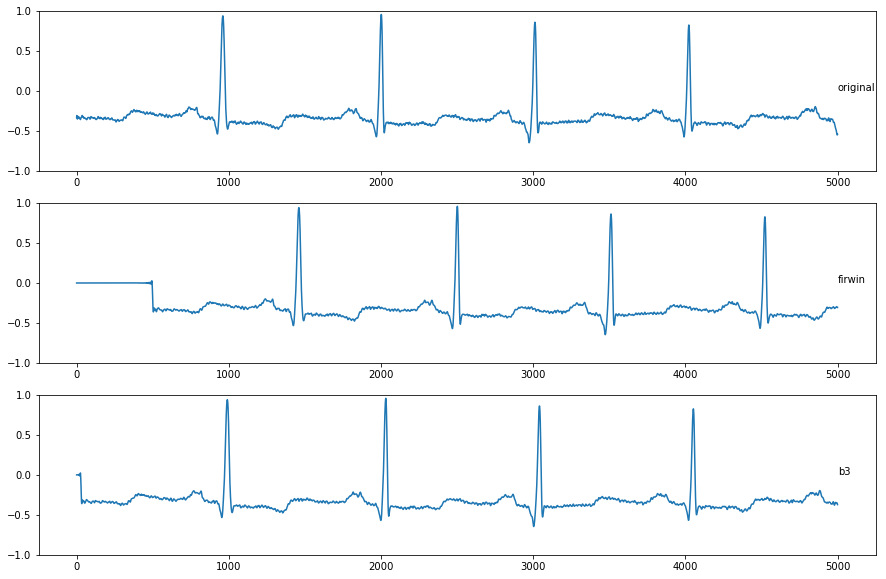

In [18]:
d_firwin = np.convolve(firwin['blackman'], data)
d_b3 = np.convolve(b3, data)
lim = 5000
plt.rcParams['figure.figsize'] = (15, 5) 
plt.subplot(311)
plt.plot(data[: lim])
plt.ylim([-1.0, 1.0])
plt.text(lim, 0, 'original')
plt.subplot(312)
plt.plot(d_firwin[: lim])
plt.ylim([-1.0, 1.0])
plt.text(lim, 0, 'firwin')
plt.subplot(313)
plt.plot(d_b3[: lim])
plt.ylim([-1.0, 1.0])
plt.text(lim, 0, 'b3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([-1.0, 1.0])
plt.show()

#### Conclusion:
The loss on the peak value is hard to avoid, since the noise and signal are close to each other on frequency domain. 

#### Apply butterworth  Low-pass filter:

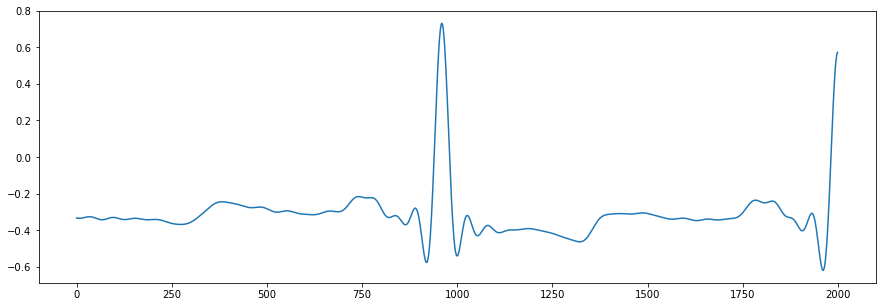

In [19]:
nom1, denom1 = signal.butter(8, 0.038, btype='low')
d_filtered = filtfilt_demo(nom1, denom1, data, (0, 2000))

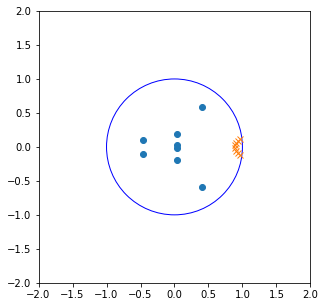

In [20]:
(r, p, k) = signal.residuez(nom1, denom1)

plt.plot(r.real, r.imag, 'o')
plt.plot(p.real, p.imag, 'x')
circ = plt.Circle((0, 0), radius=1, edgecolor = 'b', facecolor = 'None')
plt.gca().add_patch(circ)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')
plt.show()

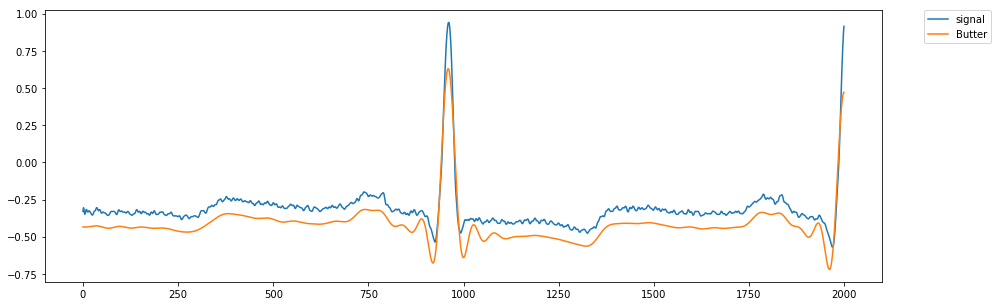

In [21]:
plt.plot(data[:2000], label = 'signal')
plt.plot(d_filtered[:2000] - 0.1, label = 'Butter')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Appling Butterworth filter, the filtered signal almost perfectly denoted the rough fluctuation of the origin heart beat signal, and the peak values got preserved as well.  
If we apply another butterworth filter to the signal and set "btype" to 'high', hopefully it will return a signal only containing high frequency component:

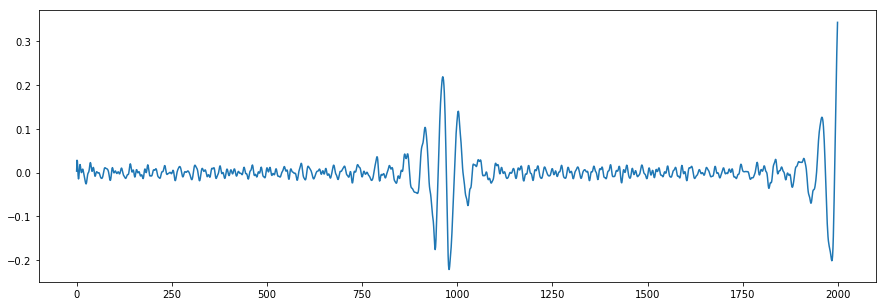

In [22]:
nom2, denom2 = signal.butter(8, 0.038, btype='high')
d2_filtered = filtfilt_demo(nom2, denom2, data, (0, 2000))

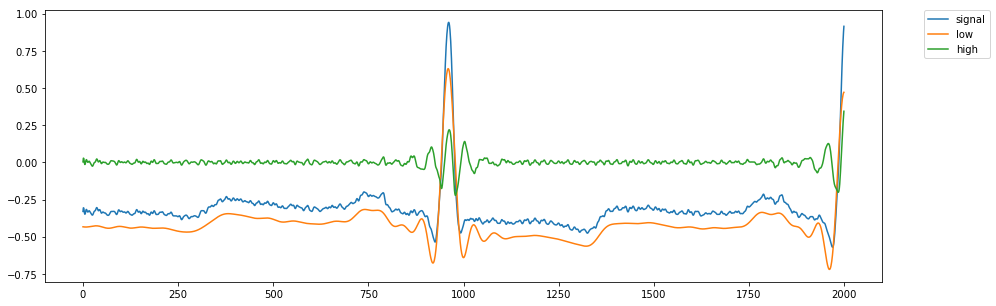

In [23]:
plt.plot(data[:2000], label = 'signal')
plt.plot(d_filtered[:2000] - 0.1, label = 'low')
plt.plot(d2_filtered[:2000], label = 'high')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The d2_filtered has bulges where the peaks appear in the original signal. It's natural to think about floating the d2_filtered, than we could obtain more ideal d_filtered using new d2_filtered (minus original signal):

In [24]:
k = int(len(data) / 256)
r = len(data) % 256

for i in range(1, k):
    d2_filtered[i * 256 + 1: (i + 1) * 256] = data[0: 255] - np.mean(data[0: 255])
d2_filtered[len(data) - r: len(data) - 1] = data[255 - r + 1: 255] - np.mean(data[0: 255])

mini = min(d2_filtered[0: 750])
maxi = max(d2_filtered[0: 750])

for i in range(len(data)):
    if d2_filtered[i] > maxi: d2_filtered[i] = maxi
    elif d2_filtered[i] < mini: d2_filtered[i] = mini

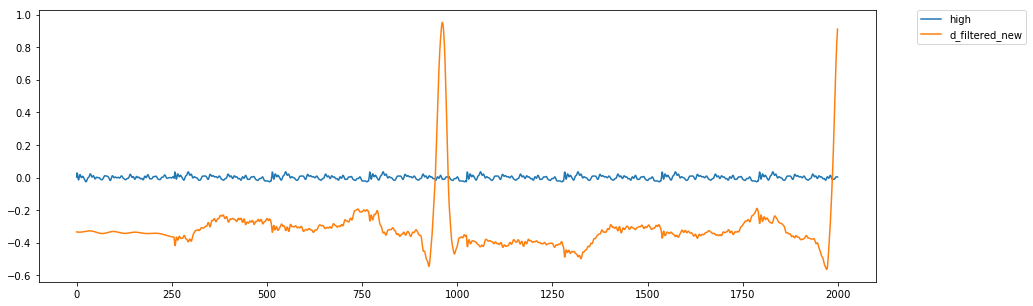

In [25]:
plt.plot(d2_filtered[:2000], label = 'high')
plt.plot(data[: 2000] - d2_filtered[:2000], label = 'd_filtered_new')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The attempt didn't work out, mainly because we lost both a lot of low and high frequency information when filtering.

C:\Users\akimoto\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


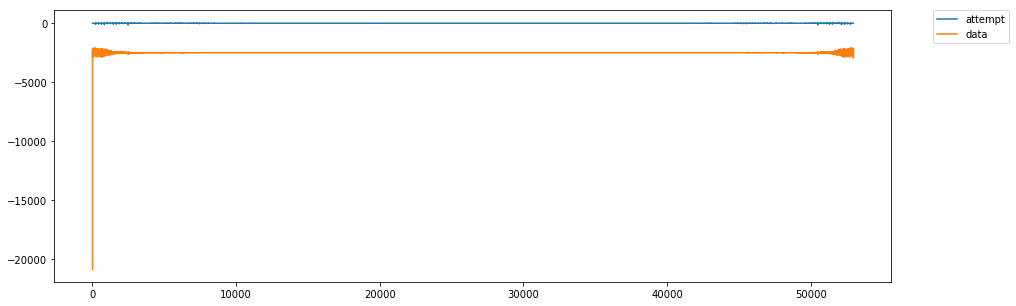

In [26]:
plt.plot(np.fft.fft(d2_filtered), label = 'attempt')
plt.plot(np.fft.fft(data) - 2500, label = 'data')
#plt.xlim([0, 200])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()